### Importing zip file from kaggle

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [2]:
!kaggle datasets download -d jessicali9530/coil100

 95% 121M/127M [00:01<00:00, 66.2MB/s]
100% 127M/127M [00:01<00:00, 67.4MB/s]


In [3]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: coil-100/coil-100/obj37__280.png  
  inflating: coil-100/coil-100/obj37__285.png  
  inflating: coil-100/coil-100/obj37__290.png  
  inflating: coil-100/coil-100/obj37__295.png  
  inflating: coil-100/coil-100/obj37__30.png  
  inflating: coil-100/coil-100/obj37__300.png  
  inflating: coil-100/coil-100/obj37__305.png  
  inflating: coil-100/coil-100/obj37__310.png  
  inflating: coil-100/coil-100/obj37__315.png  
  inflating: coil-100/coil-100/obj37__320.png  
  inflating: coil-100/coil-100/obj37__325.png  
  inflating: coil-100/coil-100/obj37__330.png  
  inflating: coil-100/coil-100/obj37__335.png  
  inflating: coil-100/coil-100/obj37__340.png  
  inflating: coil-100/coil-100/obj37__345.png  
  inflating: coil-100/coil-100/obj37__35.png  
  inflating: coil-100/coil-100/obj37__350.png  
  inflating: coil-100/coil-100/obj37__355.png  
  inflating: coil-100/coil-100/obj37__40.png  
  inflating: coil-100/coil-100/obj37__45

### Importing libraries

In [4]:
import numpy as np
import pandas as pd
import glob,string
import codecs
from tqdm import tqdm

### Converting images zip file into a dataset

In [5]:
path = 'coil-100/coil-100/*.png'
files=glob.glob(path)

In [6]:
def createdataset(file_list):
    data=[]
    for file in tqdm(file_list):
        data.append((file,file.split("/")[-1].split("__")[0]))
    return pd.DataFrame(data,columns=['path','label'])

In [7]:
df=createdataset(files)

100%|██████████| 7200/7200 [00:00<00:00, 558588.85it/s]


In [8]:
df.head(10)

path  label
0   coil-100/coil-100/obj70__45.png  obj70
1  coil-100/coil-100/obj86__165.png  obj86
2  coil-100/coil-100/obj37__120.png  obj37
3  coil-100/coil-100/obj23__115.png  obj23
4  coil-100/coil-100/obj80__110.png  obj80
5  coil-100/coil-100/obj41__295.png  obj41
6   coil-100/coil-100/obj2__245.png   obj2
7  coil-100/coil-100/obj27__220.png  obj27
8    coil-100/coil-100/obj17__5.png  obj17
9  coil-100/coil-100/obj34__180.png  obj34

### EDA

<Axes: >

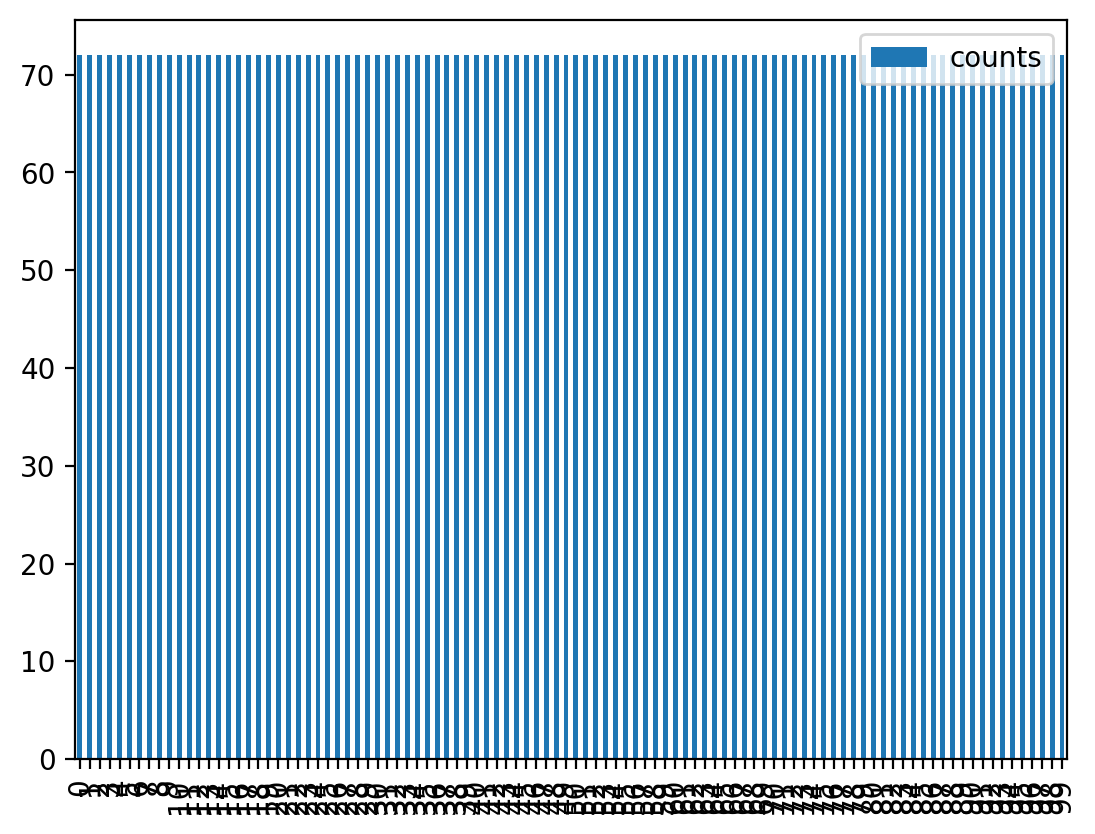

In [9]:
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
counts=df.groupby(df.label).size().reset_index(name="counts")
counts.plot.bar()

We can see that dataset is balanced with 72 images per each object

### Splitting of data

In [10]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(df.path, df.label, test_size=0.2,random_state=0,stratify= df.label)

In [11]:
print("training images = ", train_images.shape, "training labels = ", train_labels.shape)
print("testing images = ", test_images.shape, "testing labels = ", test_labels.shape)

training images =  (5760,) training labels =  (5760,)
testing images =  (1440,) testing labels =  (1440,)


<Axes: >

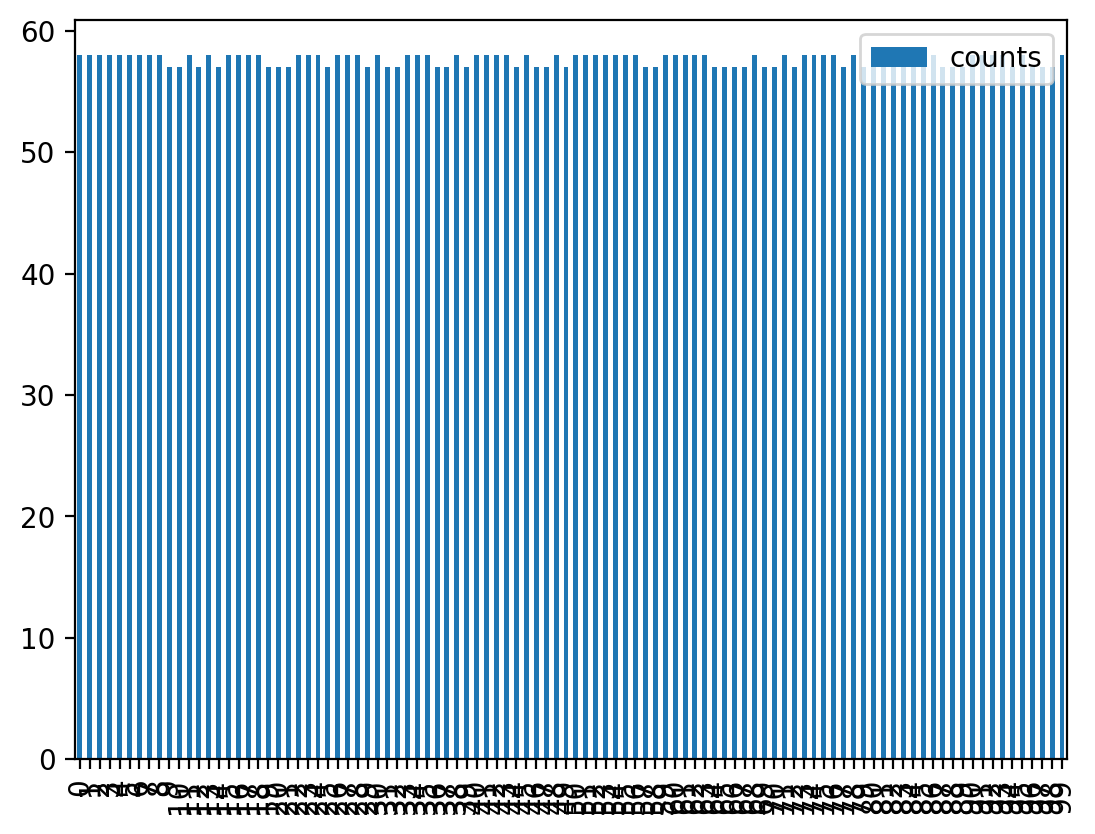

In [12]:
train_images.groupby(train_labels).size().reset_index(name="counts").plot.bar()

<Axes: >

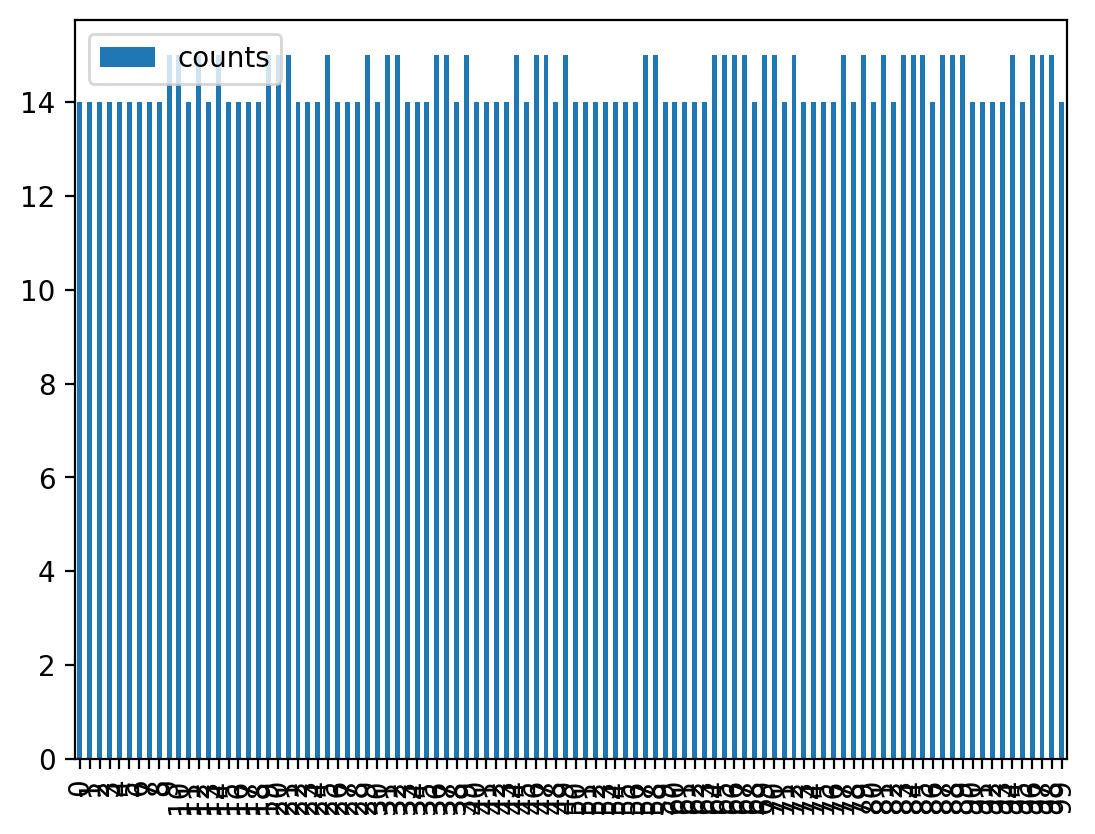

In [13]:
test_images.groupby(test_labels).size().reset_index(name="counts").plot.bar()


Both datasets are mostly balanced by using stratified

### Import images

In [14]:
from keras.preprocessing.image import load_img,img_to_array
import cv2
train_images=[img_to_array(cv2.imread(file).astype("float")/255.0) for file in tqdm(train_images.values)]

100%|██████████| 5760/5760 [00:04<00:00, 1286.14it/s]


In [15]:
test_images=[img_to_array(cv2.imread(file).astype("float")/255.0) for file in tqdm(test_images.values)]

100%|██████████| 1440/1440 [00:01<00:00, 1301.65it/s]


### Image Visualization

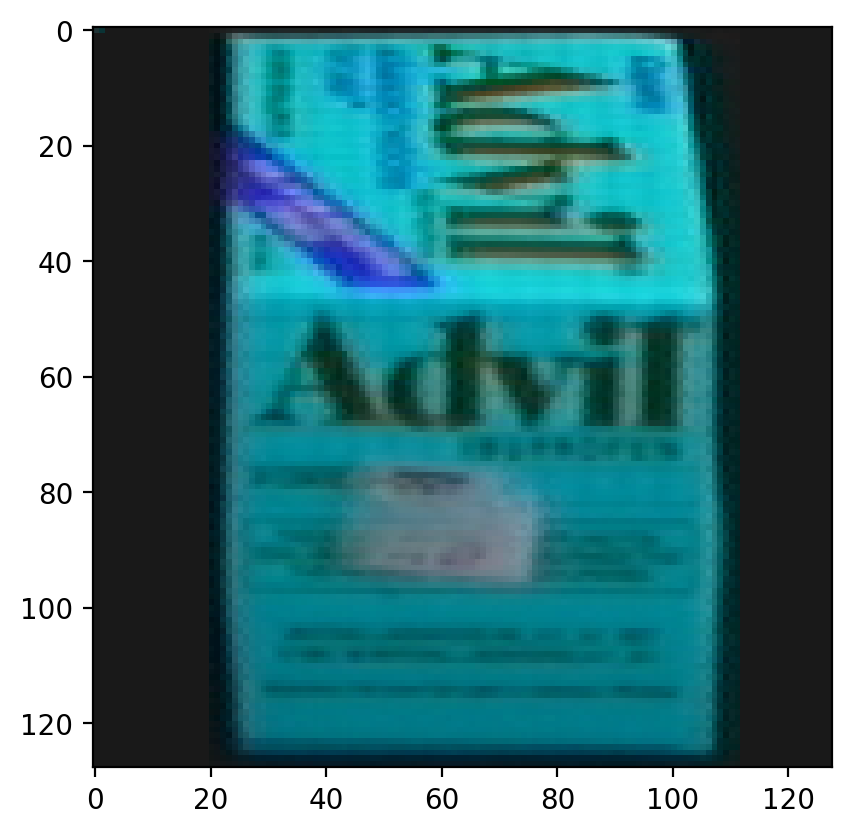

In [16]:
import matplotlib.pyplot as plt
img = train_images[0]
plt.imshow(img)
plt.show()

### One hot encoding

In [17]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
train_labels_categorical=encoder.fit_transform(train_labels.values.reshape(-1, 1))
test_labels_categorical=encoder.transform(test_labels.values.reshape(-1, 1))

### Model Building

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense
from keras.optimizers import Adam
from keras.layers import BatchNormalization

def build(width, height, depth, classes):

    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(128, 128, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    return model

In [19]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
model=build(128,128,3,encoder.classes_.__len__())
model.summary()
opt = Adam(lr=INIT_LR)
model.compile(loss="CategoricalCrossentropy", optimizer=opt,metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 32)        128       
 chNormalization)                                                
                                                        

### Validation dataset

In [20]:
train_images=np.array(train_images)
test_images=np.array(test_images)

In [21]:
train_images, validation_images, train_labels_categorical, validation_labels_categorical = train_test_split(train_images, train_labels_categorical, test_size=0.2,random_state=0,stratify= train_labels_categorical)

In [22]:
print("training images = ", train_images.shape, "training labels categorical = ", train_labels_categorical.shape)
print("validation images= ", validation_images.shape, "validation labels categorical = ", validation_labels_categorical.shape)

training images =  (4608, 128, 128, 3) training labels categorical =  (4608, 100)
validation images=  (1152, 128, 128, 3) validation labels categorical =  (1152, 100)


In [23]:
history = model.fit(train_images, train_labels_categorical, batch_size=64, epochs=50, validation_data=(validation_images, validation_labels_categorical))

Epoch 1/50
72/72 [==============================] - 19s 40ms/step - loss: 0.7517 - accuracy: 0.8277 - val_loss: 7.3925 - val_accuracy: 0.0191
Epoch 2/50
72/72 [==============================] - 2s 31ms/step - loss: 0.0988 - accuracy: 0.9742 - val_loss: 13.9736 - val_accuracy: 0.0234
Epoch 3/50
72/72 [==============================] - 2s 33ms/step - loss: 0.0763 - accuracy: 0.9831 - val_loss: 16.2236 - val_accuracy: 0.0304
Epoch 4/50
72/72 [==============================] - 2s 31ms/step - loss: 0.0659 - accuracy: 0.9846 - val_loss: 11.1392 - val_accuracy: 0.0521
Epoch 5/50
72/72 [==============================] - 2s 31ms/step - loss: 0.0756 - accuracy: 0.9794 - val_loss: 14.1876 - val_accuracy: 0.1137
Epoch 6/50
72/72 [==============================] - 2s 32ms/step - loss: 0.0771 - accuracy: 0.9820 - val_loss: 2.5662 - val_accuracy: 0.5842
Epoch 7/50
72/72 [==============================] - 2s 31ms/step - loss: 0.0438 - accuracy: 0.9883 - val_loss: 2.3857 - val_accuracy: 0.6415
Epoch 8/

In [24]:
loss, accuracy = model.evaluate(test_images,test_labels_categorical, verbose=0)
print('Accuracy: %f' % (accuracy*100),'loss: %f' % (loss*100))

Accuracy: 99.930555 loss: 0.060187


In [25]:
loss, accuracy = model.evaluate(train_images,train_labels_categorical, verbose=0)
print('Accuracy: %f' % (accuracy*100),'loss: %f' % (loss*100))

Accuracy: 100.000000 loss: 0.000111


In [26]:
loss, accuracy = model.evaluate(validation_images,validation_labels_categorical, verbose=0)
print('Accuracy: %f' % (accuracy*100),'loss: %f' % (loss*100))

Accuracy: 100.000000 loss: 0.007367


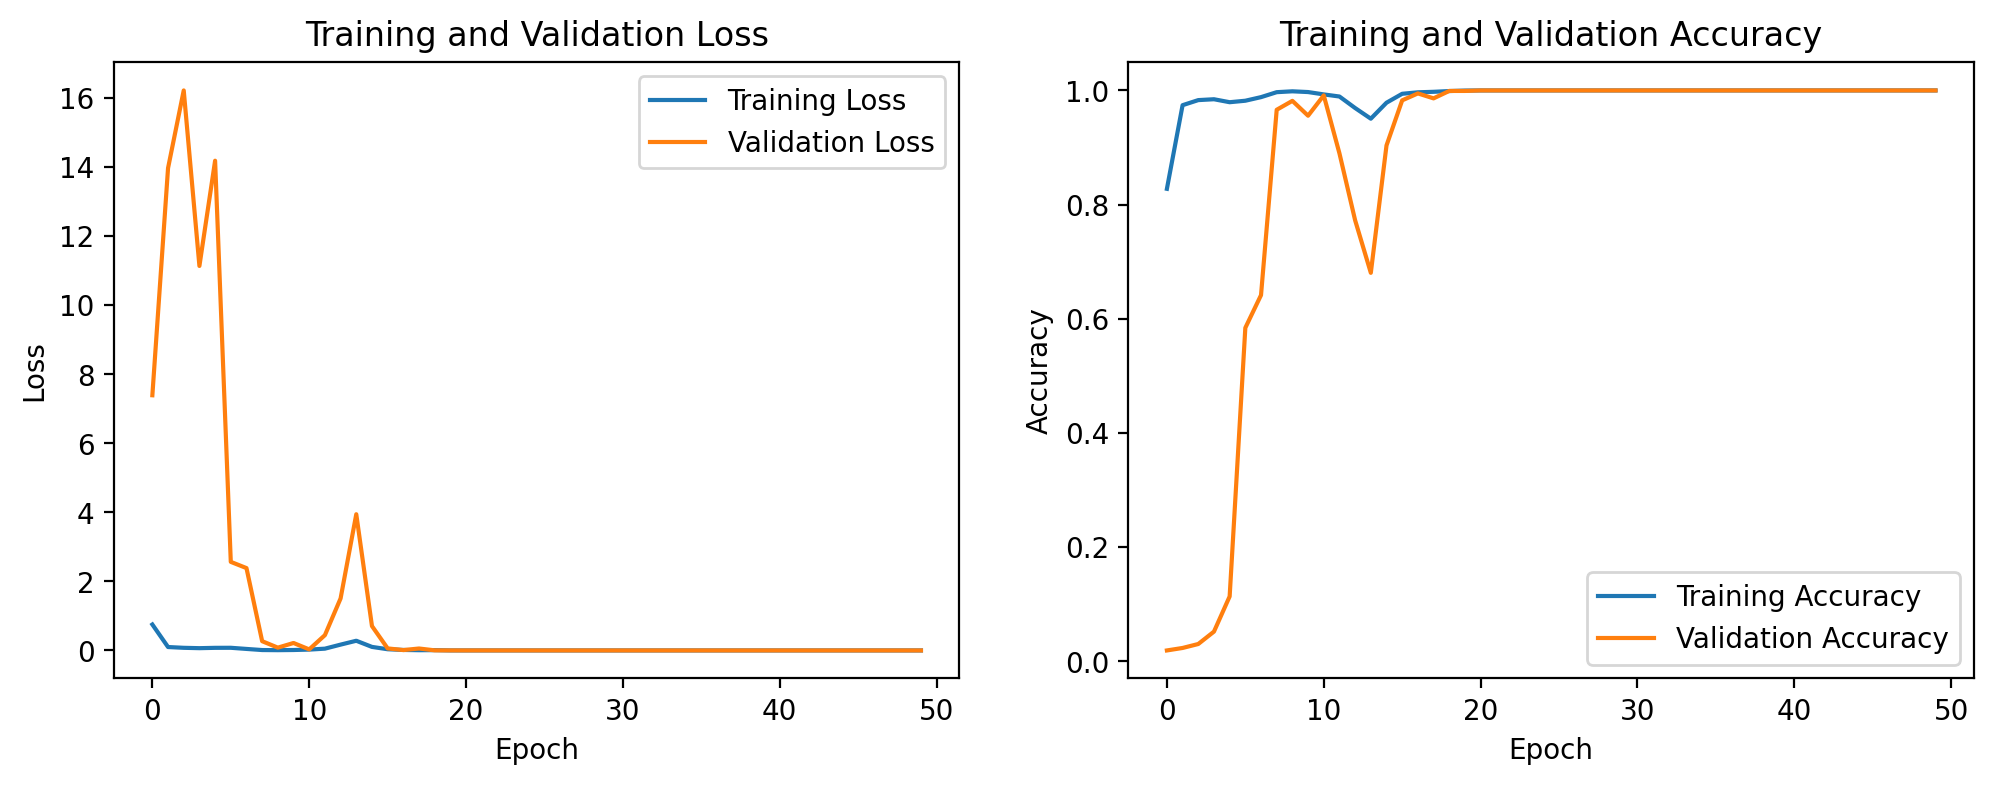

In [27]:
# Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [28]:
prediction_test_c=model.predict(test_images)
prediction_test=encoder.inverse_transform(prediction_test_c)

45/45 [==============================] - 0s 6ms/step


In [29]:
from sklearn.metrics import confusion_matrix
%config InlineBackend.figure_format = 'retina'
def plot_cm(y,y_predict,classes,name):
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y,y_predict),
            xticklabels=classes,
            yticklabels=classes)
    plt.title(name)
    plt.show()

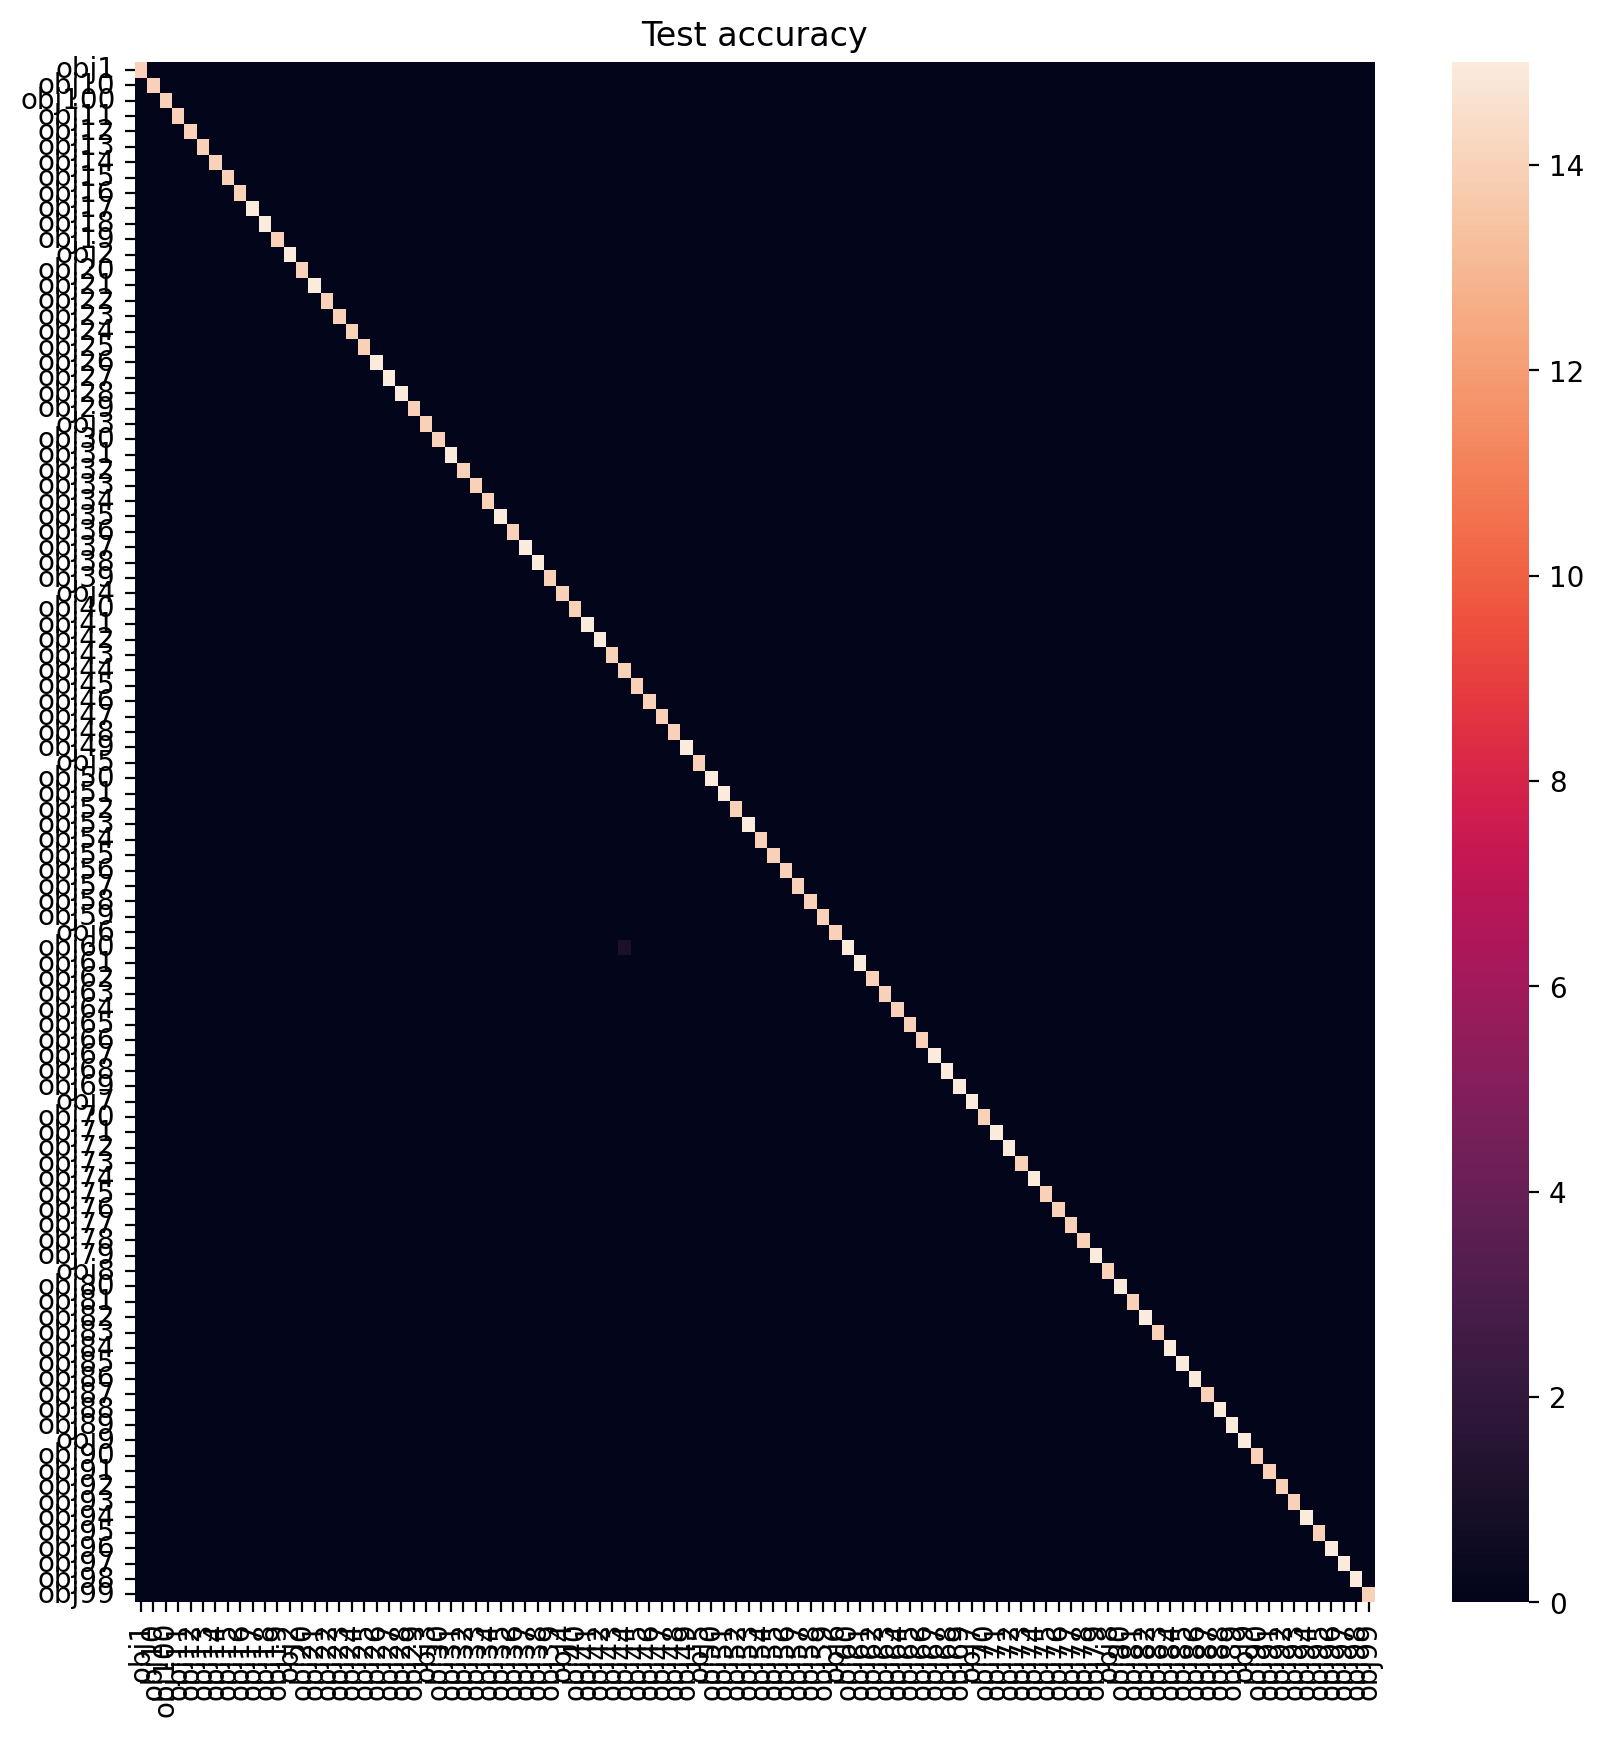

In [30]:
plot_cm(prediction_test,test_labels.values,encoder.classes_,"Test accuracy")

In [31]:
from sklearn.metrics import classification_report
print("\nClassification Report for Test Set:")
print(classification_report(test_labels, prediction_test))


Classification Report for Test Set:
              precision    recall  f1-score   support

        obj1       1.00      1.00      1.00        14
       obj10       1.00      1.00      1.00        14
      obj100       1.00      1.00      1.00        14
       obj11       1.00      1.00      1.00        14
       obj12       1.00      1.00      1.00        14
       obj13       1.00      1.00      1.00        14
       obj14       1.00      1.00      1.00        14
       obj15       1.00      1.00      1.00        14
       obj16       1.00      1.00      1.00        14
       obj17       1.00      1.00      1.00        15
       obj18       1.00      1.00      1.00        15
       obj19       1.00      1.00      1.00        14
        obj2       1.00      1.00      1.00        15
       obj20       1.00      1.00      1.00        14
       obj21       1.00      1.00      1.00        15
       obj22       1.00      1.00      1.00        14
       obj23       1.00      1.00      1.00 

In [32]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
n_classes = 100
fpr = []
tpr = []
roc_auc = []
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(test_labels_categorical[:, i], prediction_test_c[:, i])
    roc_auc_i = auc(fpr_i, tpr_i)

    fpr.append(fpr_i)
    tpr.append(tpr_i)
    roc_auc.append(roc_auc_i)

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr_macro = fpr_grid
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

print(f"Macro-averaged One-vs-Rest ROC AUC score: {roc_auc_macro:.2f}")

Macro-averaged One-vs-Rest ROC AUC score: 1.00


In [33]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr = []
tpr = []
roc_auc = []

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(test_labels_categorical.ravel(), prediction_test_c.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc_micro:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00


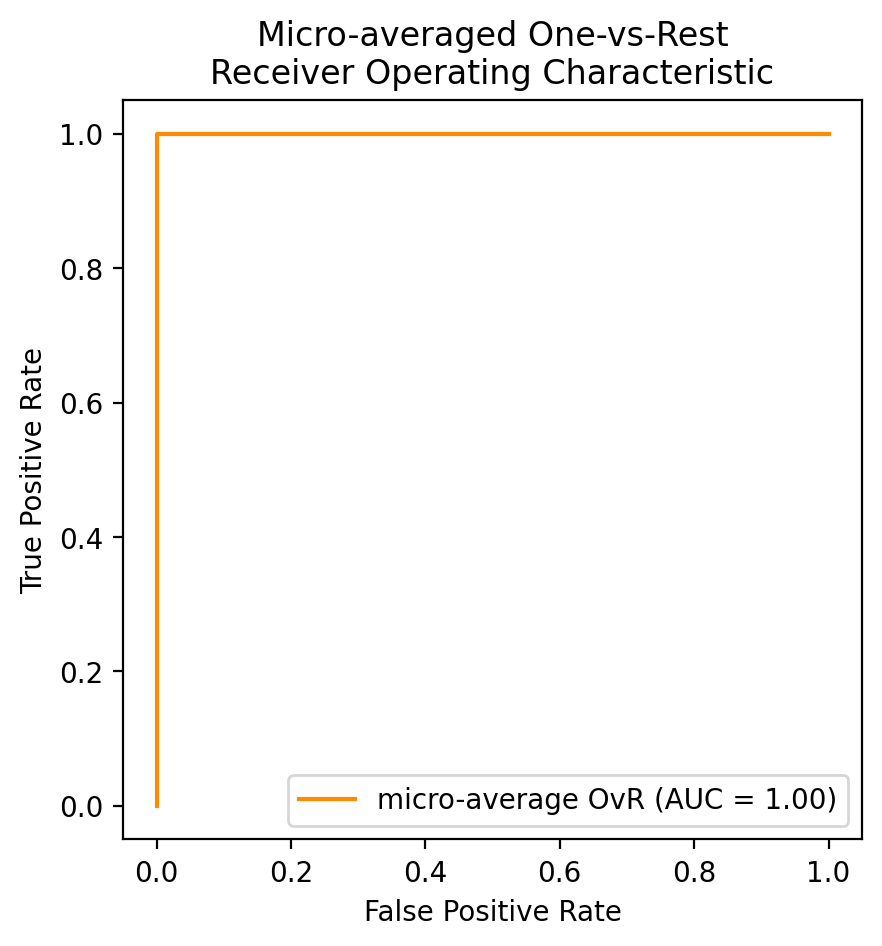

In [34]:
RocCurveDisplay.from_predictions(
    test_labels_categorical.ravel(),
    prediction_test_c.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

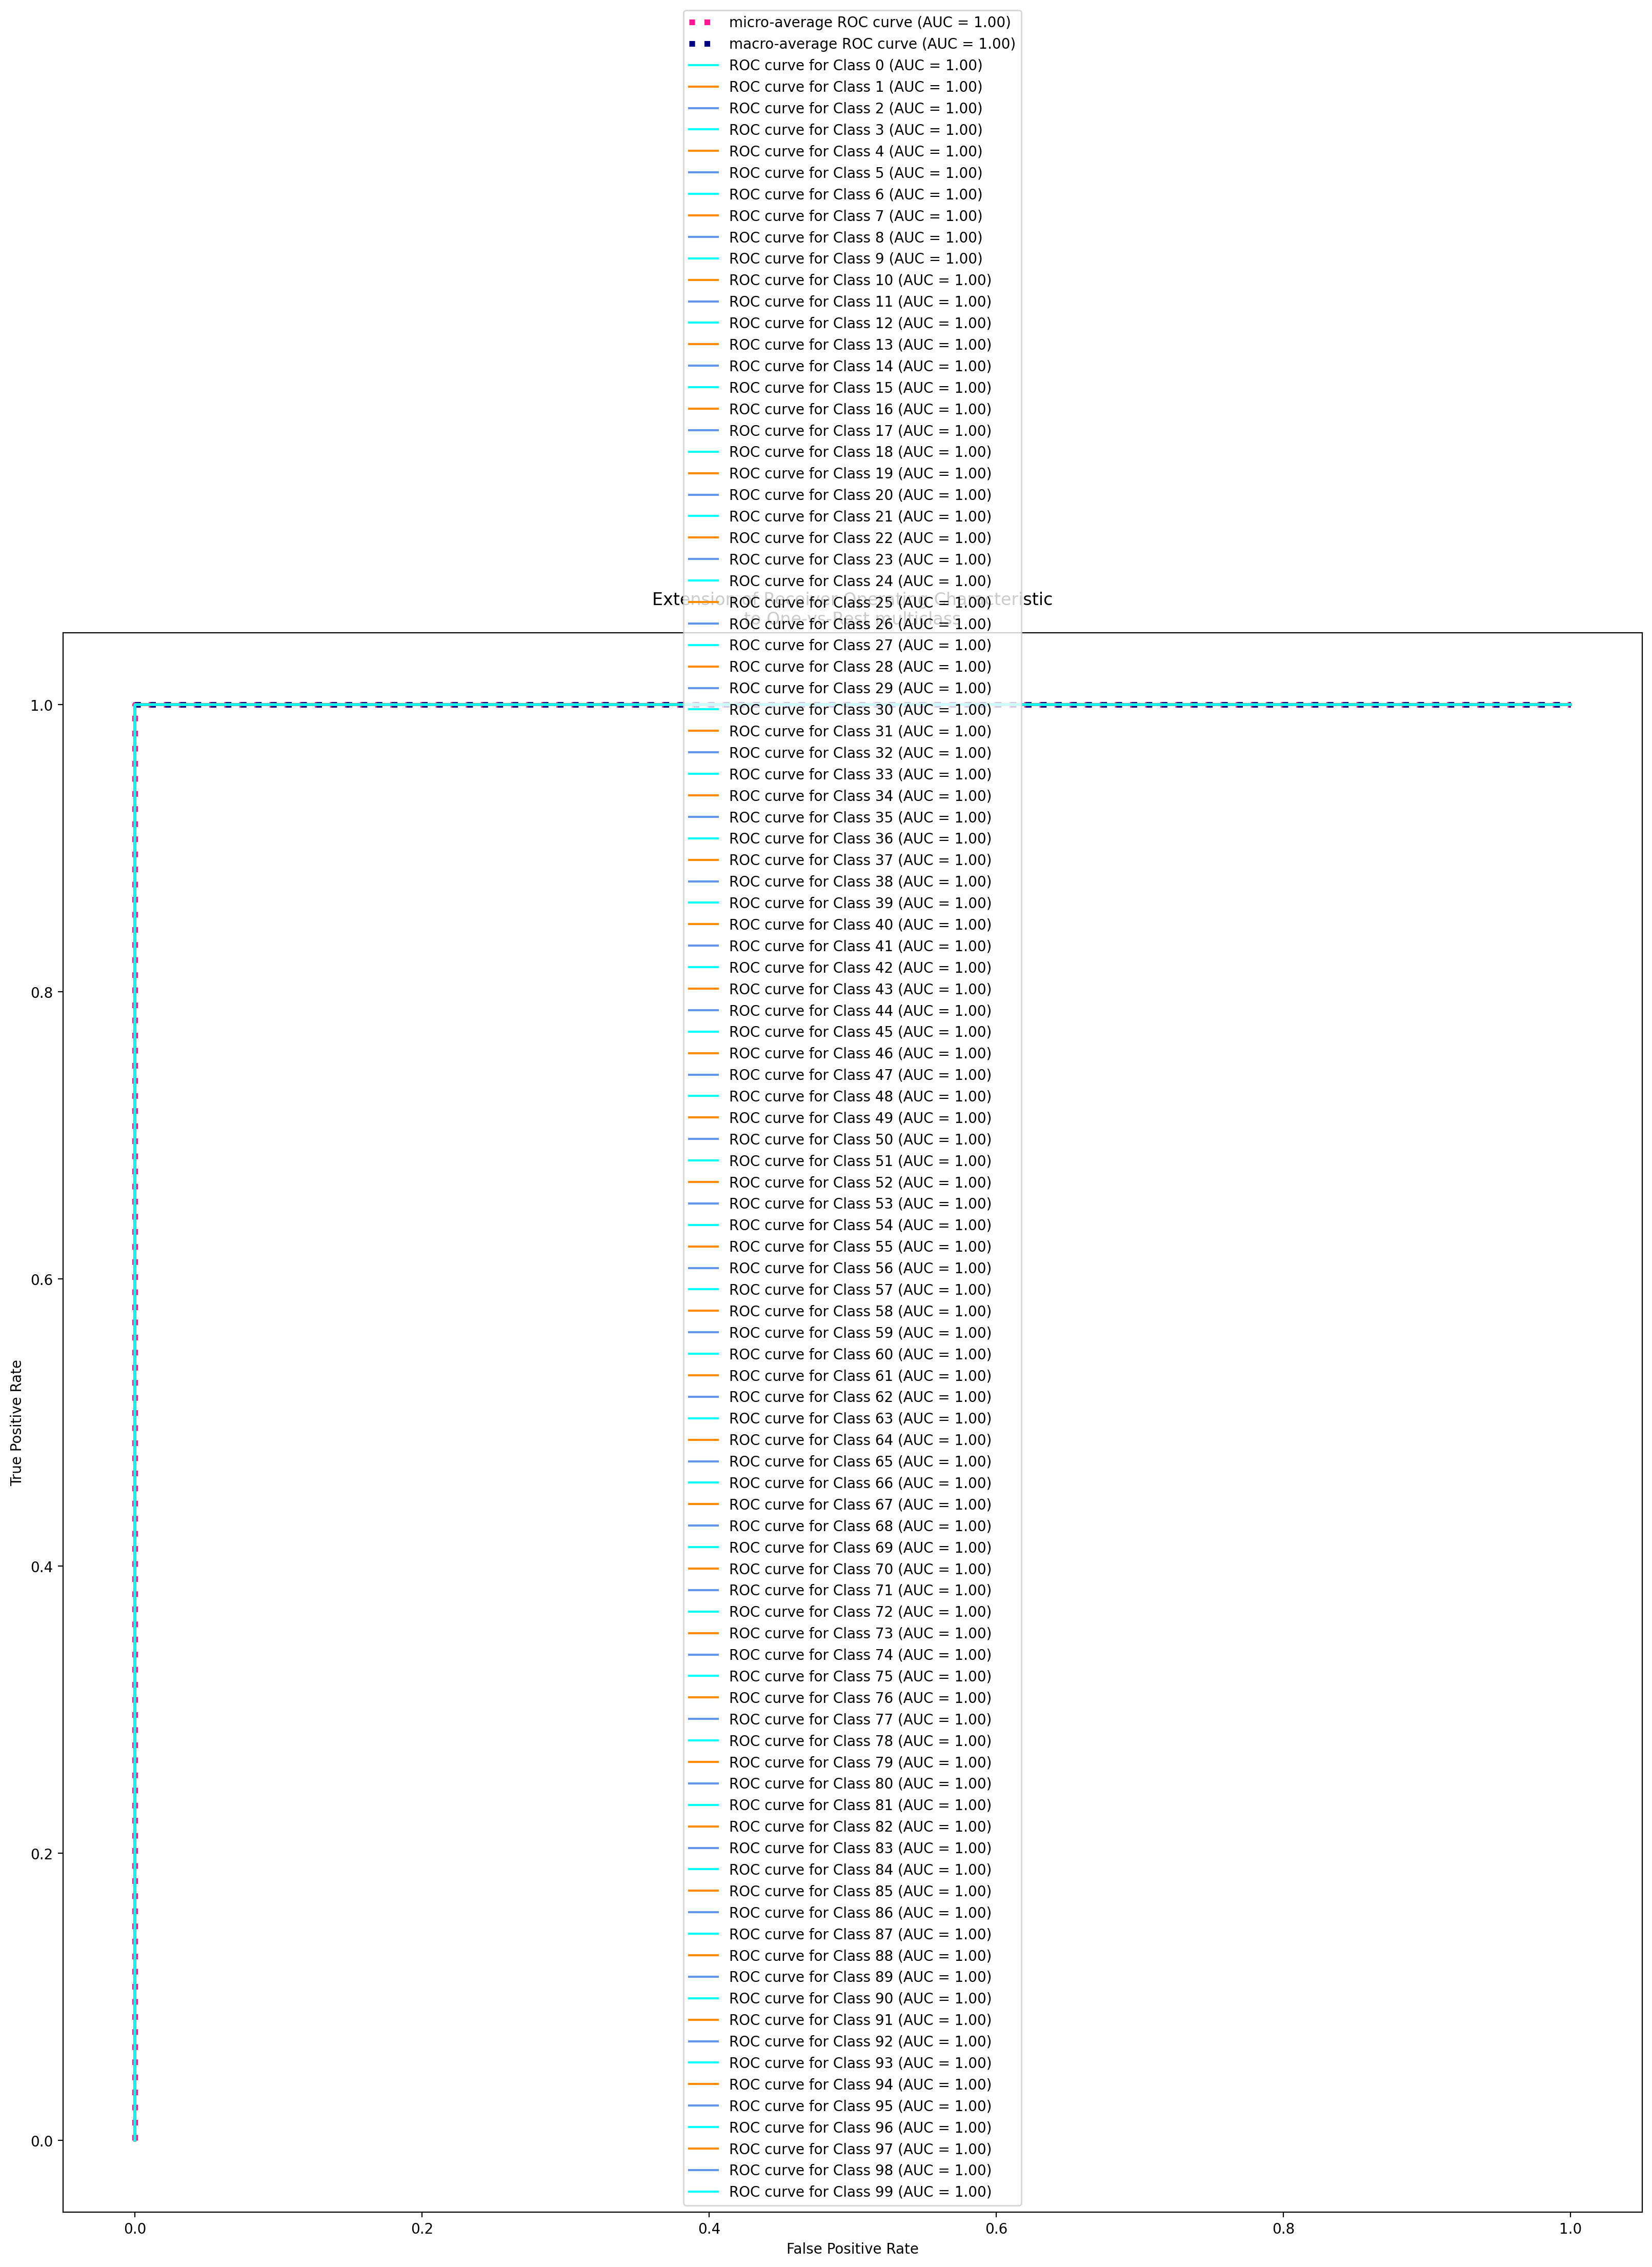

In [35]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(20,20))

plt.plot(
    fpr_micro,
    tpr_micro,
    label=f"micro-average ROC curve (AUC = {roc_auc_macro:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr_macro,
    tpr_macro,
    label=f"macro-average ROC curve (AUC = {roc_auc_macro:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        test_labels_categorical[:, class_id],
        prediction_test_c[:, class_id],
        name=f"ROC curve for Class {class_id}",
        color=color,
        ax=ax,
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

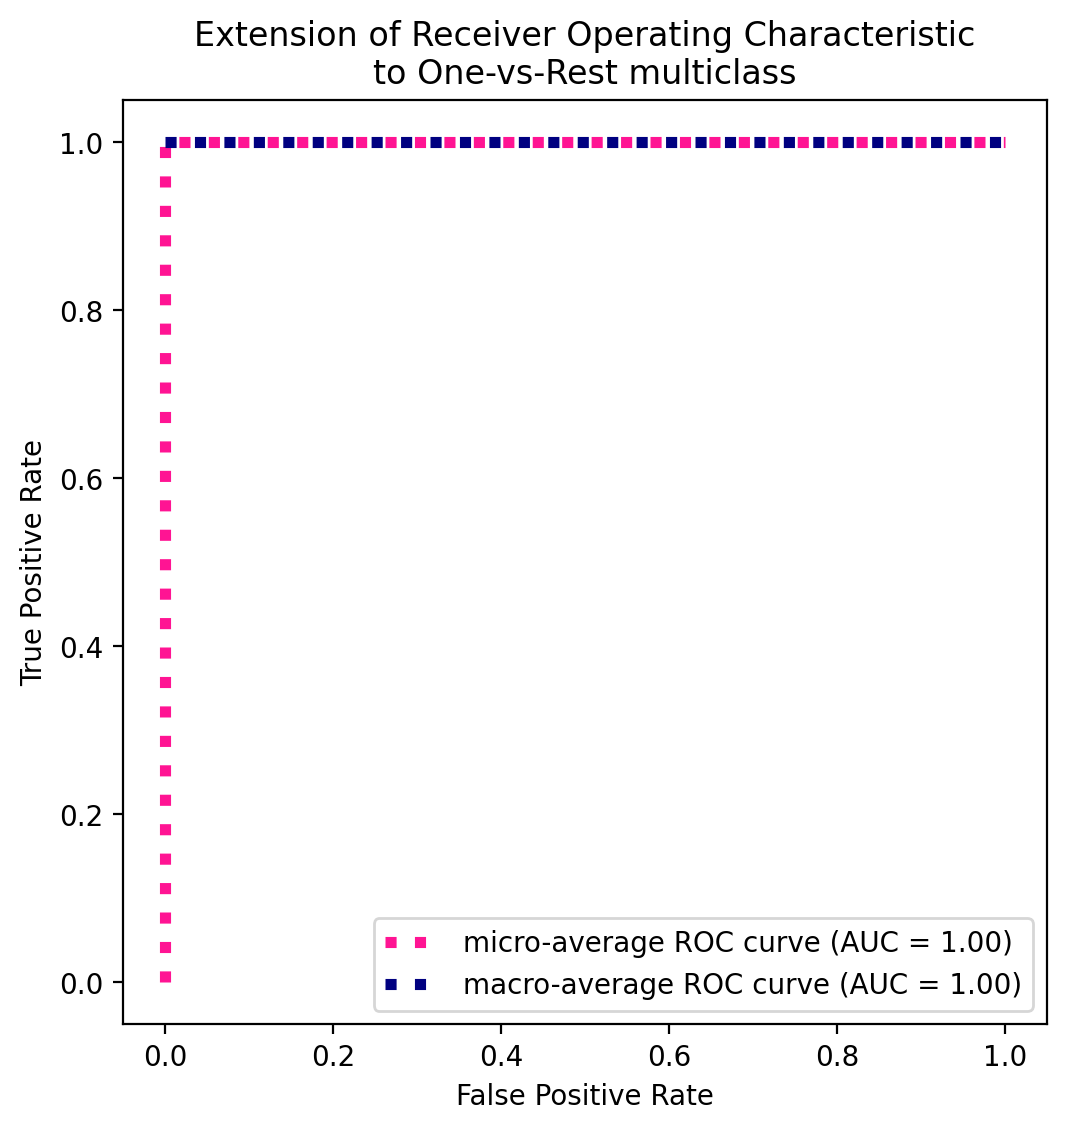

In [36]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6,6))

plt.plot(
    fpr_micro,
    tpr_micro,
    label=f"micro-average ROC curve (AUC = {roc_auc_macro:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr_macro,
    tpr_macro,
    label=f"macro-average ROC curve (AUC = {roc_auc_macro:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
n_classes = 100
# For each class
precision = []
recall = []
average_precision = []
for i in range(n_classes):
    precision_i, recall_i, _ = precision_recall_curve(test_labels_categorical[:, i], prediction_test_c[:, i])
    average_precision_i = average_precision_score(test_labels_categorical[:, i], prediction_test_c[:, i])

    precision.append(precision_i)
    recall.append(recall_i)
    average_precision.append(average_precision_i)

# A "micro-average": quantifying score on all classes jointly
precision_micro, recall_micro, _ = precision_recall_curve(test_labels_categorical.ravel(), prediction_test_c.ravel())
average_precision_micro = average_precision_score(test_labels_categorical, prediction_test_c, average="micro")

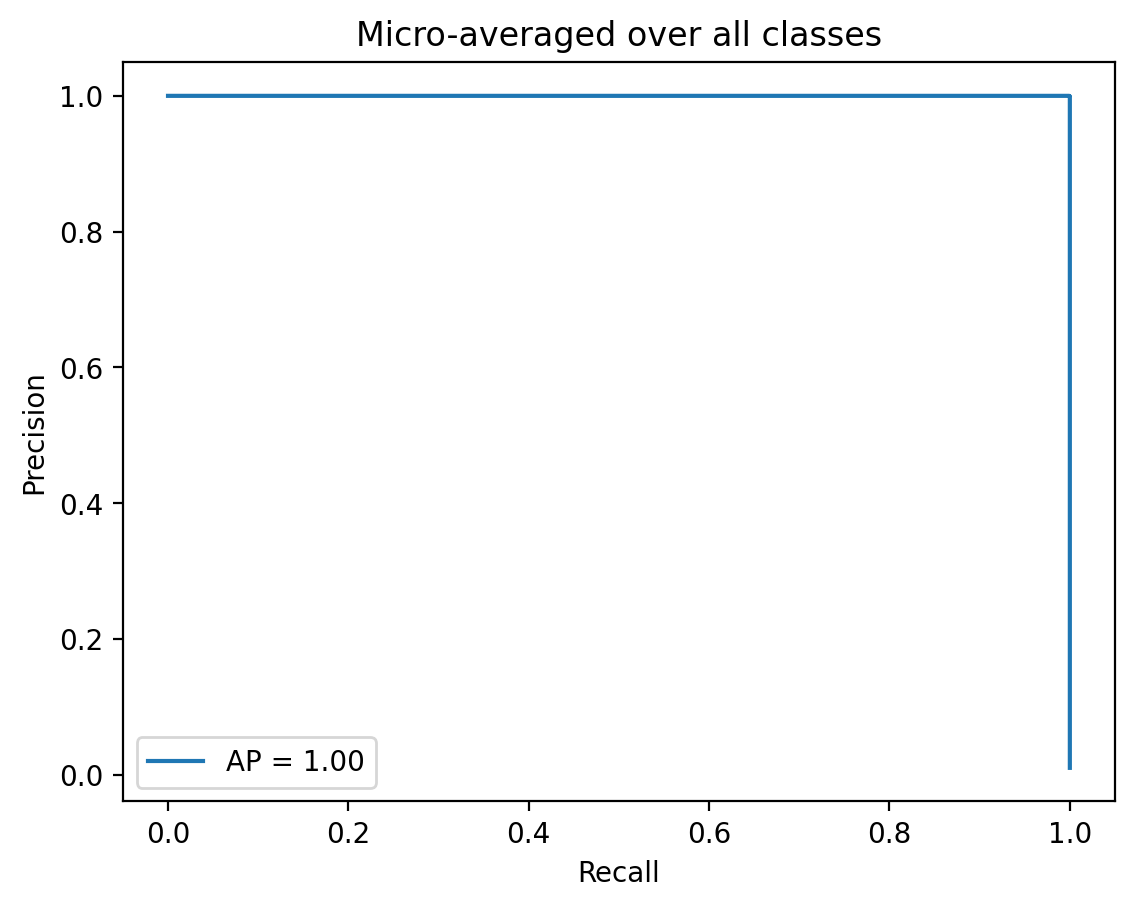

In [38]:
from collections import Counter

display = PrecisionRecallDisplay(
    recall=recall_micro,
    precision=precision_micro,
    average_precision=average_precision_micro,
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

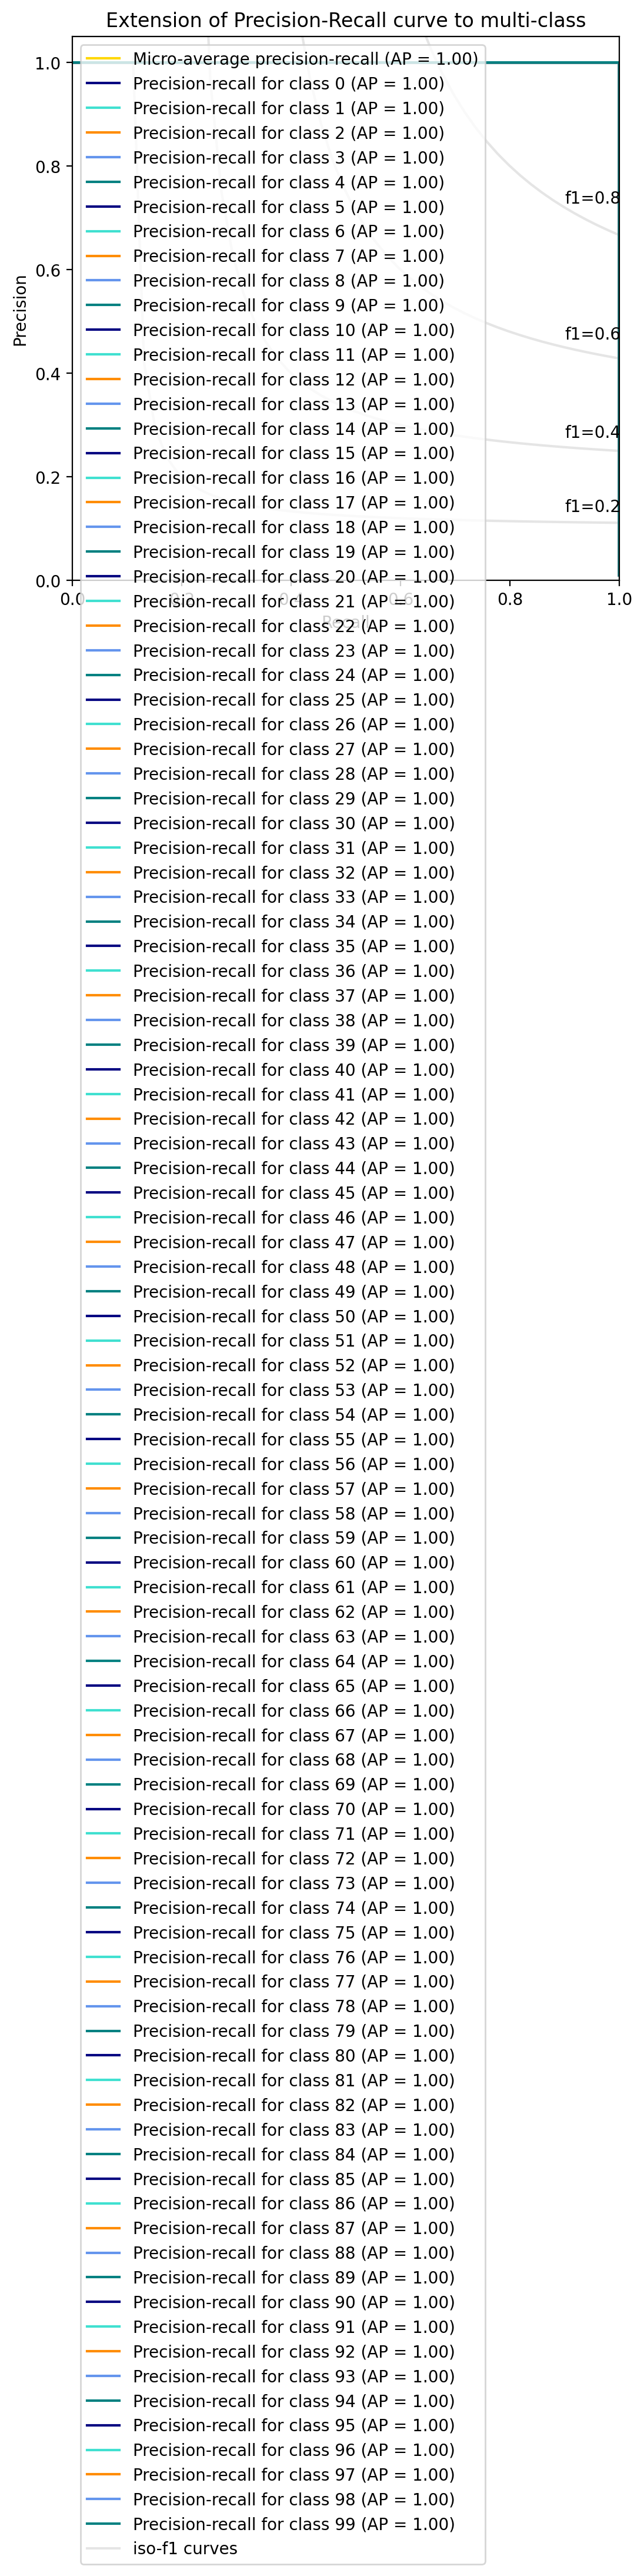

In [39]:
from itertools import cycle

import matplotlib.pyplot as plt

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(10, 10))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall_micro,
    precision=precision_micro,
    average_precision=average_precision_micro,
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall_i,
        precision=precision_i,
        average_precision=average_precision_i,
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

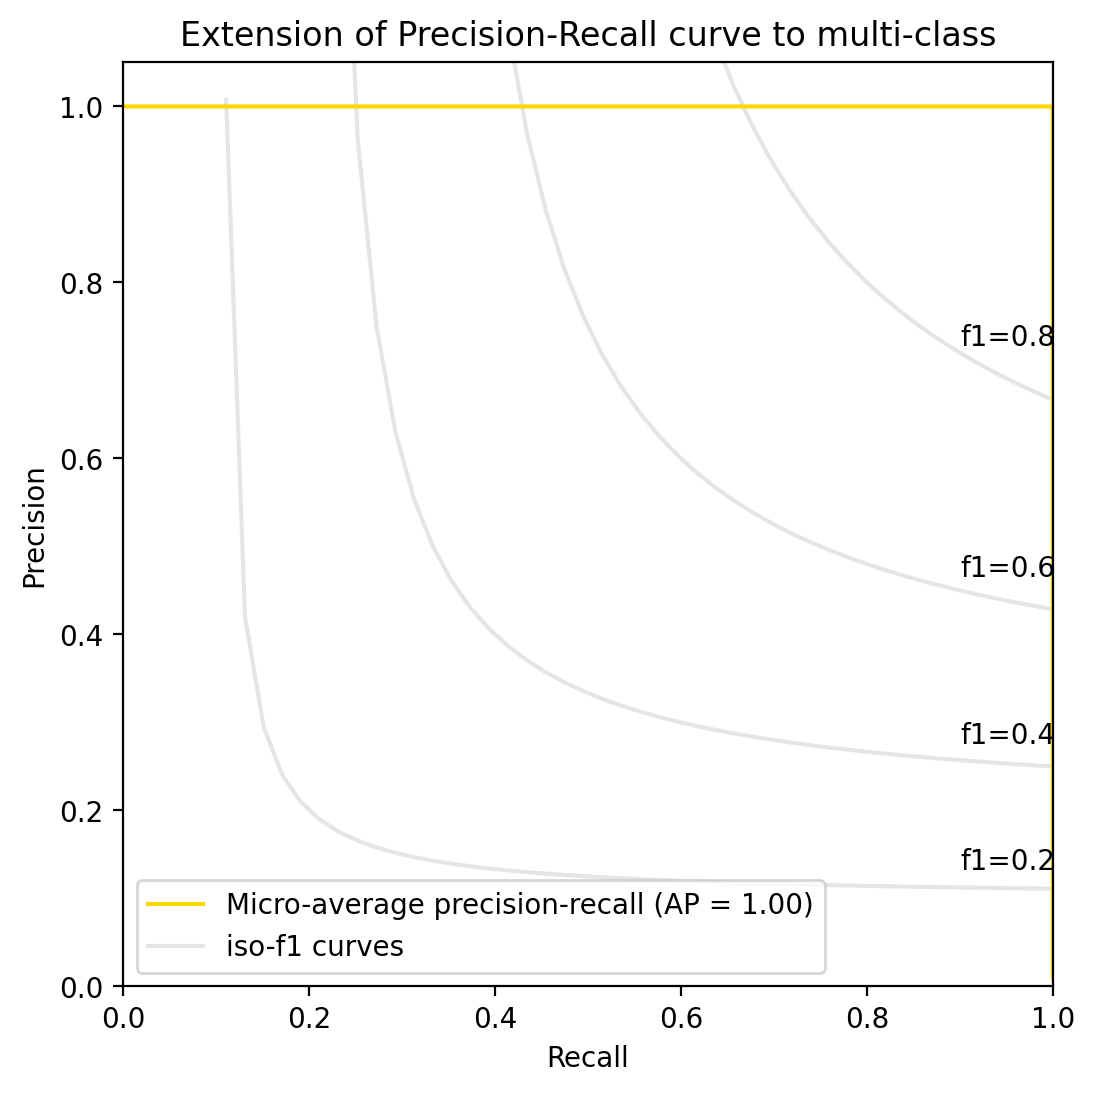

In [40]:
from itertools import cycle

import matplotlib.pyplot as plt

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(6, 6))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall_micro,
    precision=precision_micro,
    average_precision=average_precision_micro,
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")


# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()